In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


In [3]:
from keras.preprocessing.image import ImageDataGenerator

data_path="../input/waste-class/split-garbage-dataset"

train_datagen=ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2)
train_gen=train_datagen.flow_from_directory(data_path + '/train',
                                             target_size=(224,224),
                                             batch_size=64,
                                             class_mode='categorical')

val_datagen = ImageDataGenerator(rescale = 1./255)
val_gen=val_datagen.flow_from_directory(data_path + '/valid',
                                             target_size=(224,224),
                                             batch_size=1,
                                             class_mode='categorical',
                                             shuffle=False)

Found 5304 images belonging to 6 classes.
Found 328 images belonging to 6 classes.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet169,VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input
basemodel=ResNet101V2(include_top=False,
                    weights='imagenet')
basemodel.trainable = False



171319296/171317808 [==============================] - 2s 0us/step


In [19]:
basemodel.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [21]:
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout

model = Sequential()
model.add(basemodel)
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units
# add densely-connected NN layer with 6 hidden units
# add densely-connected NN layer with 128 hidden units
                      
model.add(Dense(units=6, activation='softmax'))

In [26]:
opt=tf.keras.optimizers.Adam(learning_rate=0.001)


In [27]:
model.compile(optimizer = opt,
              loss='squared_hinge',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, None, None, 2048)  42626560  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3078      
Total params: 43,680,774
Trainable params: 1,053,190
Non-trainable params: 42,627,584
__________________________________

In [38]:
history = model.fit(x=train_gen,validation_data=val_gen,epochs=15)

Epoch 1/15
83/83 [==============================] - 81s 979ms/step - loss: 0.8476 - accuracy: 0.9804 - val_loss: 0.9135 - val_accuracy: 0.8720
Epoch 2/15
83/83 [==============================] - 81s 978ms/step - loss: 0.8468 - accuracy: 0.9817 - val_loss: 0.9176 - val_accuracy: 0.8659
Epoch 3/15
83/83 [==============================] - 81s 982ms/step - loss: 0.8453 - accuracy: 0.9840 - val_loss: 0.9129 - val_accuracy: 0.8720
Epoch 4/15
83/83 [==============================] - 81s 978ms/step - loss: 0.8452 - accuracy: 0.9840 - val_loss: 0.9135 - val_accuracy: 0.8689
Epoch 5/15
83/83 [==============================] - 82s 989ms/step - loss: 0.8423 - accuracy: 0.9889 - val_loss: 0.9045 - val_accuracy: 0.8902
Epoch 6/15
83/83 [==============================] - 82s 987ms/step - loss: 0.8426 - accuracy: 0.9870 - val_loss: 0.9044 - val_accuracy: 0.8902
Epoch 7/15
83/83 [==============================] - 84s 1s/step - loss: 0.8436 - accuracy: 0.9870 - val_loss: 0.9065 - val_accuracy: 0.8933
Ep

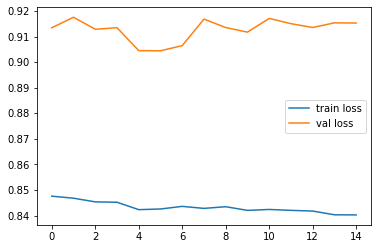

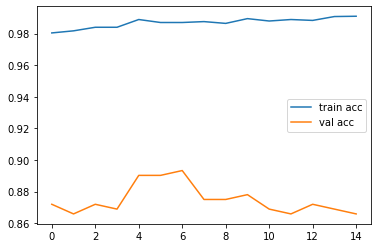

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [40]:
model.save('resnet101V2.h5')

In [41]:
from tensorflow.keras.models import load_model
model=load_model('resnet101V2.h5')
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, None, None, 2048)  42626560  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3078      
Total params: 43,680,774
Trainable params: 1,053,190
Non-trainable params: 42,627,584
__________________________________

In [47]:
data_path="../input/waste-class/split-garbage-dataset"

test_datagen= ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(data_path + '/test',
                                              target_size=(224,224),
                                              batch_size=1,
                                              class_mode='categorical',
                                              shuffle=False)

SyntaxError: positional argument follows keyword argument (<ipython-input-47-6d4886e730bb>, line 9)

In [44]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

Text(0.5, 1.0, 'Confusion matrix of model')

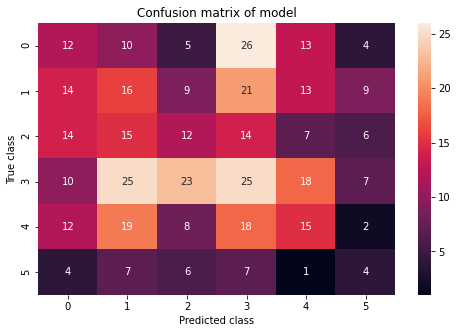

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score
cf_matrix = confusion_matrix(test_gen.classes, y_pred)
import seaborn as sns
plt.figure(figsize=(8,5))
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

In [46]:
accuracy_score(test_gen.classes, y_pred)


0.19489559164733178